# Program - Plot SCAM cn_tp, xy_seris, xy_profile

**Purpose**
Plot SCAM cn_tp, xy_seris, xy_profile

**Content**
- read data
- plot SCAM cn_tp, xy_seris, xy_profile

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** 
November 2023

**Reference program:**



In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Functions

### Read data

In [19]:
def read_scam_data (choice, datapath="/Users/yi-hsuanchen/Downloads/yihsuan/scripts/python/data_test/"): 

    func_name = "read_scam_data"
    
    if (choice == "scam_tw606_cam5phys"):        
        fname = datapath+"scam_tw606_cam5phys.camrun.cam.h0.2006-01-17-10800.nc"
        scm_list = {'fname':fname,
                    'label':'CAM5_phys',
                    'ln_style':'b-',
                   }
        
    else:
        error_msg = f"ERROR: function [{func_name}] does not support [{choice}]."
        raise ValueError(error_msg)        
    
    #--- read files
    da_return = xr.open_mfdataset(fname) 

    return da_return, scm_list

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"

    da1, scm_list1 = read_scam_data(choice)    
    
#da1
#scm_list1['label']

### ax_def_xy_series

In [20]:
def ax_def_xy_series (ax, var, scm_list):

    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    #ax.grid(False, axis = "x")  # turn off x grids
    
    #--- inverse axes
    #ax.invert_yaxis()
    
    #--- set title
    fontsize_title = 18
    #ax.set_title(var.attrs['long_name'], loc='left')
    ax.set_title(var.attrs['units'], loc='right')
      ### set font size, ax.set_title(var.attrs['units'], loc='right', fontsize = fontsize_title)

    #--- set x or y labels
    fontsize_label = 18
    #ax.set_ylabel(var.attrs['long_name']+" ("+var.attrs['units']+")")
    ax.set_xlabel("Time step")  
      ### set font size, ax.set_ylabel("A", fontsize = fontsize_label)
    
    #--- set x range
    ax.set_xlim([0,len(var)])
    
    #--- set x tickmark
    #xvalues = np.arange()
    #xlabels = np.arange()
    #ax.set_xticks(xvalues)        # tickmark values
    #ax.set_xticklabels(xlabels)  # tickmark labels

    #--- set tick mark sizes
    fontsize_tm = 12  # set tick mark size
    ax.tick_params(axis='x', labelsize = fontsize_tm)
    ax.tick_params(axis='y', labelsize = fontsize_tm)

### Plot - xy_series

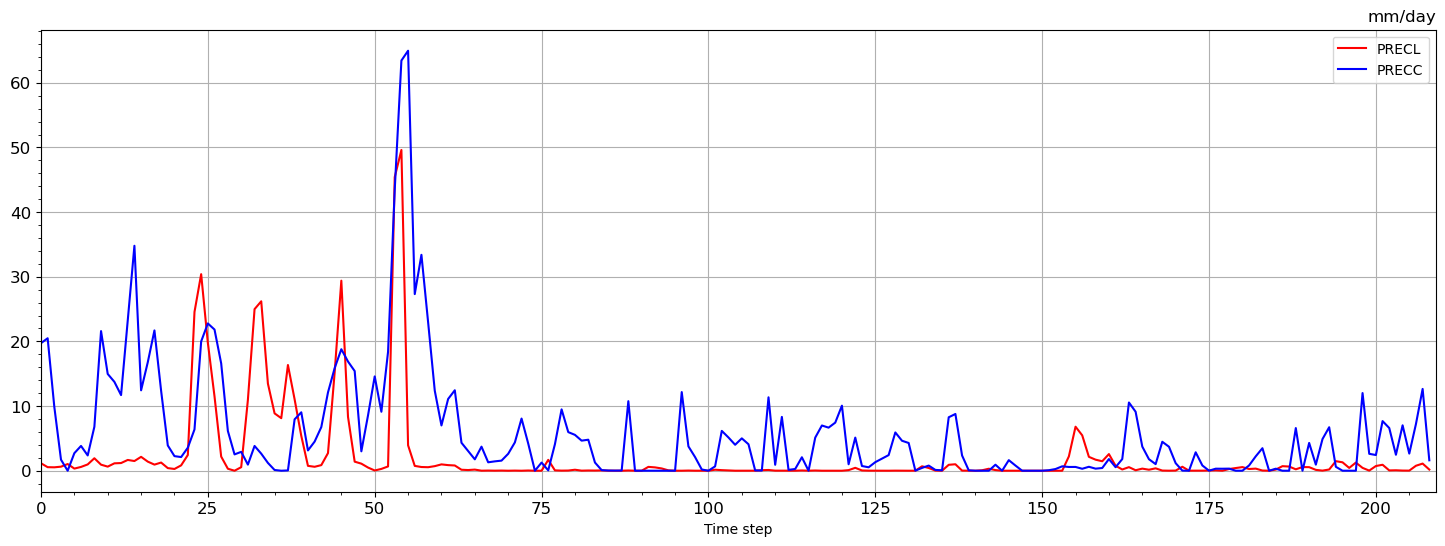

In [21]:
def plot_scam_xy_series(ax, da, scm_list, 
                        varname,
                        ln="b-", label="LABEL",
                        unit_in=None, unit_out=None):
    
    var = yhc.unit_convert(da.get(varname)[:,0,0])

    #var_time = var.time
    var_step = np.arange(0, len(var.time))
    
    #print(var_step)
    
    ax1.plot(var_step, var, ln, label=label,
             )
    
    ax1.legend()
    ax_def_xy_series(ax1, var, scm_list)
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"
    da1, scm_list1 = read_scam_data(choice)    
    
    varname = "PRECL"

    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    plot_scam_xy_series(ax1, da1, scm_list1, varname="PRECL", ln="r-", label="PRECL")
    plot_scam_xy_series(ax1, da1, scm_list1, varname="PRECC", label="PRECC")
    #plot_scam_xy_series(ax1, da1, scm_list1, varname="FLUT", ln="r--", label="FLUT")
    #plot_scam_xy_series(ax1, da1, scm_list1, varname="FLDS")



In [15]:
yhc.lib('pltxy')


    #-------------
    #
    # matplotlib.pyplot for XY plots
    #
    #-------------  

    #--- XY line styles  
    #    * Line colors, https://matplotlib.org/stable/gallery/color/named_colors.html
    #        red (r), blue (b), green (g), cyan (c), magenta (m), yellow (y), black (k), white (w)
    #
    #.   * Line dash pattern, https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
    #.       {'-', '--', '-.', ':'} {solid, dashed, dashdot, dotted}
    #
    #.   * Markers, https://matplotlib.org/stable/api/markers_api.html
    #        {'.', 'o', '^', 's'} = {point, circle, triangle_up, square}  

    #--- plot  
    ax1.plot(xx1, yy1, 'r',
             xx2, yy2, 'b--',
             )
    ax1.plot(xx1, yy1, 'k-^, label="test")

    ax1.plot(xx3, yy3, label='1st data', c='orange', ls='-.', lw=5.)  # set labe, color, linestyle, and linewidth

    #--- add legend 
    #.     https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    #------

### Plot - cn_tp

In [ ]:
def plot_scam_cn_tp(da, varname):
    

### Plot - xy_profile

## Plot - 

In [ ]:
#yhc.lib("fdef")   # check out yhc library